# Lab #4: Gibbs and Metropolis Hastings Sampling
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
from functools import partial
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Outline
1. Gibbs on a Bivariate Gaussian
2. Gibbs versus Metropolis Hastings on a Bivariate Gaussian
2. Metropolis Hastings on a Mixture of Gaussians

## Gibbs on a Bivariate Gaussian

Implement a Gibbs sampler to sample from the following bivariate Gaussian (you can look up the formulae for the conditionals of a bivariate Gaussian):

$$
\mathcal{N}\left([120, 4], \left[\begin{array}{cc} 3& 1\\ 1 & 3 \end{array} \right] \right)
$$

Scatter plot the samples with the Gaussian pdf, connect consecutive samples with a line so that you can see how the sampler moves in the sample space. 

Visually check for convergence of your chain. Apply the appropriate amount of burn-in and thinnning to an appropriate choice of number of total samples.

Explore the effect of your choice of initialization on the performance of your sampler.

Implement a Gibbs sampler to sample from a different bivariate Gaussian:

$$
\mathcal{N}\left([120, 4], \left[\begin{array}{cc} 10.2& 10\\ 10 & 10.2 \end{array} \right] \right)
$$

Again, scatter plot the samples with the Gaussian pdf, connect consecutive samples with a line so that you can see how the sampler moves in the sample space. 

Discuss how the shape of the Gaussian affects the performance of the sampler. How do you explain what you observe?

**Solution:**

Let's denote the first component, $X_1$, of $\mathbf{X}$, by $X$ and the second component, $X_2$, by $Y$.

Now, if $X$ and $Y$ are jointly normally distributed with $\mu = [\mu_X, \mu_Y]$ and $\Sigma = \left[\begin{array}{cc}\sigma^2_X & \rho\sigma_X\sigma_Y\\\rho\sigma_X\sigma_Y & \sigma^2_Y\end{array}\right]$. The conditionals $p(Y | X) = f_{Y\vert X}$ and $p(X | Y) = f_{X\vert Y}$ are both normal with:
\begin{align}
\mathbb{E}[Y|x] &= \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), &\text{Var}[Y|x] = \sigma_Y^2(1 - \rho)\\
\mathbb{E}[X|y] &= \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), &\text{Var}[X|y] = \sigma_X^2(1 - \rho)
\end{align}
***Note:*** The derivation of these forms are algebraically involved but not difficult, we encourage you to do it by hand once (following online notes if you'd like) to get a flavor of how to manipulate Gaussian distributions.

In our case, we see that we have $\mu_X = 120, \mu_Y = 4$, $\sigma_X = \sigma_Y = \sqrt{3}$. Then we have $\rho = \frac{\text{Cov}[X, Y]}{\sigma_X\sigma_Y} = \frac{1}{3}$.

Finally, we have that our two conditionals are:

\begin{align}
p(Y | X) &= \mathcal{N}\left( \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), \sigma_Y^2(1 - \rho)\right)\\
p(X | Y) &= \mathcal{N}\left( \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), \sigma_X^2(1 - \rho) \right)
\end{align}

Our Gibbs Sampling will consists of repeating the following two steps:

- Draw $Y$ from $p(Y | x)$
- Draw $X$ from $p(X| y)$

In [2]:
# Defining all the parts in the bivariate normal distribution
sigma_x = 3**0.5
sigma_y = 3**0.5
rho = 1. / 3
mu_x = 120
mu_y = 4


#implementation of the posterior distributions
p_x_given_y = lambda y: np.random.normal(mu_x + rho * sigma_x / sigma_y * (y - mu_y), sigma_x**2 * (1 - rho), 1)[0]
p_y_given_x = lambda x: np.random.normal(mu_y + rho * sigma_y / sigma_x * (x - mu_x), sigma_y**2 * (1 - rho), 1)[0]

#implementation of the gibbs sampler
def gibbs(p_x_given_y, p_y_given_x, iters, x_0, y_0, burn, thin=1):
    samples = [(x_0, y_0)]
    
    for i in range(iters):
        new_x = p_x_given_y(samples[-1][1])
        new_y = p_y_given_x(new_x)
        samples.append([new_x, new_y])
        
    return np.array(samples[int(burn * iters)::thin])

In [3]:
#design choices for the gibbs sampler
x_0 = -10
y_0 = -10
iters = 500
burn = .1
#run the gibbs sampler
gibbs_samples = gibbs(p_x_given_y, p_y_given_x, iters, x_0, y_0, burn)

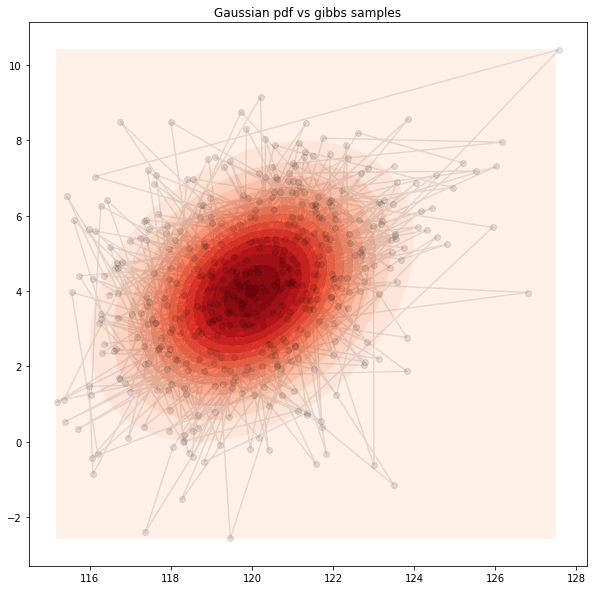

In [4]:
#mean of the multivariate Gaussian
mu = [120, 4]
#covariance matrix of the multivariate Gaussian
Sigma = np.ones((2, 2)) + 2 * np.eye(2)

#define points that include most of the probability mass of the pdf
x, y = np.mgrid[gibbs_samples[:, 0].min():gibbs_samples[:, 0].max():.1, gibbs_samples[:, 1].min():gibbs_samples[:, 1].max():.01]
pos = np.dstack((x, y))
#get the value of the pdf at those points
z = sp.stats.multivariate_normal(mu, Sigma).pdf(pos)

#plot the target density against samples
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.contourf(x, y, z, levels=14, cmap='Reds')
ax.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], color='black', alpha=0.1)
ax.plot(gibbs_samples[:, 0], gibbs_samples[:, 1], color='black', alpha=0.1)
ax.set_title('Gaussian pdf vs gibbs samples')
plt.show()

## Gibbs versus Metropolis Hastings on a Bivariate Gaussian

Implement a Metropolis-Hastings sampler for the two Gaussians in the previous problem. Keep track of the acceptance rate.

Try a bivariate Gaussian proposal distribution $\mathcal{N}(X_n, \sigma^2I_{2\times 2})$, where $I_{2\times 2}$ is the identity matrix, $X_n$ is the current sample and $\sigma^2$ is your choice of variance. Try different values of $\sigma$.

Discuss how does the shape of the Gaussian effect the performance of your sampler.

How does MH perform in comparison to Gibbs?

Try a bivariate Gaussian proposal distribution 
$$
\mathcal{N}\left(X_n, \left[\begin{array}{cc} 0.4& 0.2\\ 0.2 & 0.4 \end{array} \right] \right)
$$
where $X_n$ is the current sample. 

Does this proposal distribution perform better or worse than $\mathcal{N}(X_n, \sigma^2I_{2\times 2})$? Why do you think it does (or does not)?

In [5]:
#implementation of metropolis-hastings with symmetric proposal distribution
def MH_sampler(S, log_target, init, burn_in, thinning, Sigma=np.eye(2)):
    samples = []
    current = init
    accepts = 0
    for s in range(S):
        
        proposal = np.random.multivariate_normal(current, Sigma)
        log_proposal = lambda mu, x: -0.5 * (x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu)
        U = np.random.uniform(0, 1)
        if U < np.min((1, np.exp(log_target(proposal) - log_proposal(current, proposal)
                          - log_target(current) + log_proposal(proposal, current)))):
            samples.append(proposal)
            current = proposal
            accepts += 1
        else:
            samples.append(current)
    
            
    return np.array(samples)[burn_in::thinning, :], accepts * 1. / S

#mean of the multivariate Gaussian
mu = [120, 4]
#covariance matrix of the multivariate Gaussian
Sigma = np.ones((2, 2)) + 2 * np.eye(2)
#define the target distribution
log_target = lambda x: -0.5 * (x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu)

#total number of samples
S = 5000
#initialization of the MH sampler
init = np.array([0, 0])
#amount of samples to throw out
burn_in = 1000
#keep every n samples
thinning = 5
#proposal variance
Sigma_prop = 0.2 * np.ones((2, 2)) + 0.2 * np.eye(2)
#sample from the MH sampler
MH_samples, accepts = MH_sampler(S, log_target, init, burn_in, thinning, Sigma=Sigma_prop)

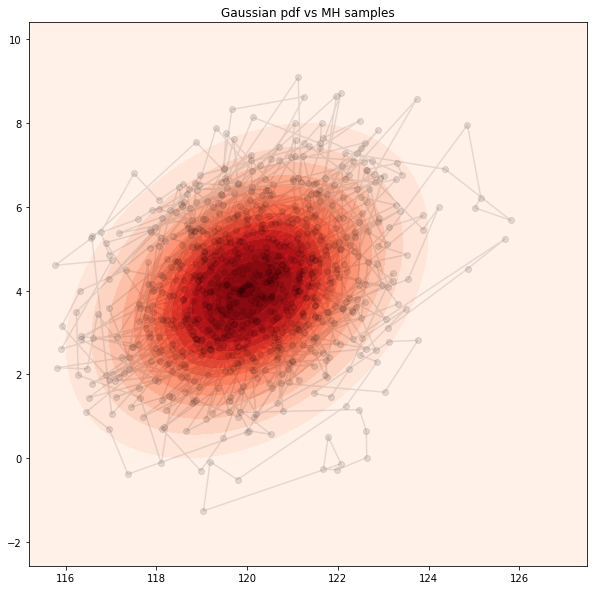

In [6]:
#define points that include most of the probability mass of the pdf
x, y = np.mgrid[gibbs_samples[:, 0].min():gibbs_samples[:, 0].max():.1, gibbs_samples[:, 1].min():gibbs_samples[:, 1].max():.01]
pos = np.dstack((x, y))
#get the value of the pdf at those points
z = sp.stats.multivariate_normal(mu, Sigma).pdf(pos)

#plot the target density against samples
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.contourf(x, y, z, levels=14, cmap='Reds')
ax.scatter(MH_samples[:, 0], MH_samples[:, 1], color='black', alpha=0.1)
ax.plot(MH_samples[:, 0], MH_samples[:, 1], color='black', alpha=0.1)
ax.set_title('Gaussian pdf vs MH samples')
plt.show()

## Metropolis Hastings on a Mixture of Gaussians

Recall the mixture of two univariate Gaussian example in class where our Metropolis-Hastings sampler was unable to capture both modes in the target distribution.

Is this because this algorithm is incapable of sampling from this specific distribution of this class of ***multimodal distributions***? Or did we make inappropriate design choices when we specified our sampler?

**Exercise:** play with the variance of the normal proposal distribution (try some very small values and some very large values), what is the effect of the variance have on the performance of your sampler? 

Play with the choice of initialization of the Metropolis-Hastings algorithm, what is the effect of the initialization on the performance of your sampler?

In [7]:
#implementation of metropolis-hastings with symmetric proposal distribution
def MH_sampler(S, target, init, sigma_sq=0.5):
    samples = []
    current = init
    accepts = 0
    for s in range(S):
        proposal = np.random.normal(current, sigma_sq**2)
        U = np.random.uniform(0, 1)
        
        if U < np.min((1, target(proposal) / target(current))):
            samples.append(proposal)
            current = proposal
            accepts += 1
        else:
            samples.append(current)
    
            
    return samples, accepts * 1. / S

#visualize target distribution and samples
def plot_samples(ax, target, samples, title):
    x = np.linspace(-5, 25, 100)
    ax.plot(x, target(x), color='black', alpha=0.9, label='target distribution')
    ax.hist(samples, density=True, bins=50, color='red', alpha=0.5, label='all samples')
    ax.set_title(title)
    ax.legend(loc='best')
    return ax

#define the target distribution as a mixture of two univariate gaussians
sigma_sqs = [1, 1]
mus = [2, 20]
pis = [0.5, 0.5]
target = lambda x: pis[0] * sp.stats.norm(mus[0], sigma_sqs[0]**2).pdf(x) + pis[1] * sp.stats.norm(mus[1], sigma_sqs[1]**2).pdf(x)

In [8]:
#total number of samples
S = 5000
#initialization of the MH sampler
init = -10
#amount of samples to throw out
burn_in = 1000
#keep every n samples
thinning = 5
#proposal variance
sigma_sq_large = 3.
#sample from the MH sampler
samples_large_var, accepts = MH_sampler(S, target, init, sigma_sq=sigma_sq_large)

#proposal variance
sigma_sq_small = 1.
#sample from the MH sampler
samples_small_var, accepts = MH_sampler(S, target, init, sigma_sq=sigma_sq_small)

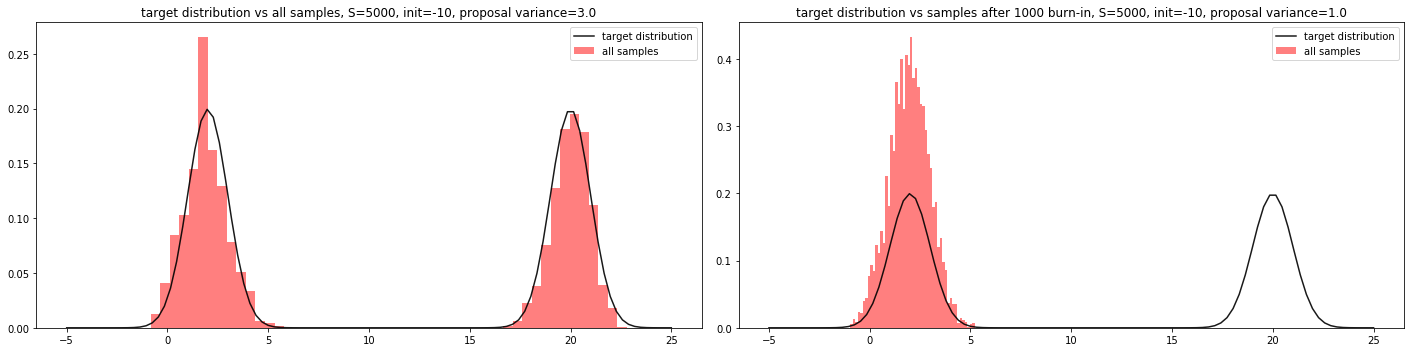

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(-5, 25, 100)
ax[0] = plot_samples(ax[0], target, samples_large_var[200:], 'target distribution vs all samples, S={}, init={}, proposal variance={}'.format(S, init, sigma_sq_large))
ax[1] = plot_samples(ax[1], target, samples_small_var[200:], 'target distribution vs samples after {} burn-in, S={}, init={}, proposal variance={}'.format(burn_in, S, init, sigma_sq_small))
plt.tight_layout()
plt.show()